## Домашнее задание: "Детекция объектов на изображении"

ФИО: Носков Алексей Александрович

## Цель задания:
Научиться самостоятельно решать задачу детекции.
## Описание задания:
В рамках данного домашнего задания предлагается решить задачу детекции мячей и настроить полный пайплайн обучения модели.

Процесс выполнения задания следующий:

0. Выбор модели детекции для обучения:
    1. Выберите модель детекции для выполнения домашнего задания. Любую, кроме RetinaNet. Ее реализацию можно взять из открытых источников. Модель можно брать предобученную ( в этом случае в пункте 4. показать влияние предобучения на финальное качество).
    2. Полезные ссылки: [PyTorch Vision Models](https://pytorch.org/vision/stable/models.html) (блок Object Detection), [SOTA модели детекции](https://paperswithcode.com/sota/object-detection-on-coco), [Возможный пример кода](https://github.com/AlekseySpasenov/dl-course/blob/autumn_2023/lecture8/detection_example/pytorch_detection_workshop.ipynb)
    3. Вы можете использовать RetinaNet, которая была реализована на семинаре, но это приведет к снижению оценки на **–2.5 балла**, так как задания 1.1 и 2.1 уже были выполнены в рамках занятия.

1. Подготовка обучающего набора данных
    0. Для выполнения задания используйте датасет с изображениями мячей, который использовался на семинаре.
    1. Реализуйте корректный класс Dataset и Dataloader для выбранной модели (должен работать форвард вашей модели на том, что выходит из даталоадера) **0.5 балла**.
    2. Добавьте простые аугментации в датасет (аугментации, не затрагивающие изменение ground-truth bounding box) **0.5 балла**.
    3. Внедрите сложные аугментации (аугментации, затрагивающие изменение ground-truth bounding box. Например, аффинные преобразования: сдвиг, поворот и т.д.) **0.5 балла**.

    4. Полезные ссылки: https://pytorch.org/vision/stable/transforms.html , https://albumentations.ai

2. Реализация корректного train-loop и обучение модели:  
    1. Реализуйте эффективный train-loop для вашей модели и проведите обучение **2 балла**.
    2. Выполните несколько запусков обучения с различными параметрами, например: сравните влияние различных аугментаций, оцените влияние того была предобучена модель или нет, сравните результаты при изменении гиперпараметров итд (на ваш выбор) **0.5 балла**.

3. Валидация обученных моделей на тестовой выборке, вычисление метрики mAP
    1. Оцените качество моделей на тестовой части данных и рассчитайте метрику mAP **0.5 балл**
    2. Полезные ссылки: [mean_average_precision](https://github.com/bes-dev/mean_average_precision)

4. Выводы **0.5 балл**:
    1. Проанализируйте результаты обучения, визуально оцените качество работы модели.
    2. Прокомментируйте распространенные ошибки модели и предложите пути для улучшения финального решения.

In [23]:
!gdown "https://drive.google.com/uc?id=1ZMPIHcEVOZx9OukDOGvmkndkVGYpmIEF" -O seminar_objdet_retina_oi5_ball.zip

Downloading...
From (original): https://drive.google.com/uc?id=1ZMPIHcEVOZx9OukDOGvmkndkVGYpmIEF
From (redirected): https://drive.google.com/uc?id=1ZMPIHcEVOZx9OukDOGvmkndkVGYpmIEF&confirm=t&uuid=9b0f99cf-de32-4a8d-94d8-e4b9db8b7f47
To: /content/seminar_objdet_retina_oi5_ball.zip
100% 1.08G/1.08G [00:19<00:00, 54.9MB/s]


In [24]:
!unzip seminar_objdet_retina_oi5_ball.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/2688.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._2688.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/1381.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._1381.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/0921.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._0921.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/0909.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._0909.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/3025.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._3025.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/1626.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._1626.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/0538.jpg  
  inflating: __MACOSX/seminar_objd

In [ ]:
import cv2
import json

import numpy as np
import torch
from tqdm import tqdm

from torch.utils.data import DataLoader
import numpy as np

import albumentations as A
from cv2 import BORDER_CONSTANT

from mean_average_precision import MetricBuilder

from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
import torchvision

if not hasattr(torchvision, '_is_tracing'):
    torchvision._is_tracing = lambda: False

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device is:", device)

import matplotlib.pyplot as plt
%matplotlib inline

Device is: cuda


In [2]:
def show_image_with_boxes(image, bboxes, figsize=(10, 10)):
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()

    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)

    image_with_boxes = image.copy()

    for bbox in bboxes:
        x1, y1, x2, y2 = map(int, bbox)
        cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), (0, 255, 0), 1)
        cv2.putText(image_with_boxes, "ball", (x1, y1-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    plt.figure(figsize=figsize)
    plt.imshow(image_with_boxes)
    plt.axis('off')
    plt.show()

In [3]:
def get_simple_augmentations():
    return A.Compose([
        A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, p=0.3),
        A.GaussianBlur(blur_limit=1, p=0.2),
    ], bbox_params=A.BboxParams(format='pascal_voc'))

def get_complex_augmentations():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=5, p=0.3),
        A.Affine(scale=(0.9, 1.1), keep_ratio=True, p=0.3),
    ], bbox_params=A.BboxParams(
        format='pascal_voc',
        min_area=100,
        min_visibility=0.5
    ))

Реализуем датасет с аугментациями:

In [4]:
class DetectionDataset(torch.utils.data.Dataset):
    def __init__(self, data_dict_file, transforms=None, add_path=None):
        self.transforms = transforms

        with open(data_dict_file, 'r') as f:
            self.data_dict = json.load(f)
        if add_path:
            self.data_dict = {add_path + i:j for i,j in self.data_dict.items()}

        self.imgs = list(self.data_dict.keys())

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.
        h, w = image.shape[:2]

        num_boxes = len(self.data_dict[img_path])
        boxes = []
        for i in range(num_boxes):
            bbox = self.data_dict[img_path][i]
            xmin = bbox[0] * w
            xmax = bbox[1] * w
            ymin = bbox[2] * h
            ymax = bbox[3] * h
            boxes.append([xmin, ymin, xmax, ymax])

        sample = {'img': image, 'bboxes': boxes}

        if self.transforms:
            sample = self.transforms(sample)

        return sample

    def __len__(self):
        return len(self.imgs)

    def image_aspect_ratio(self, image_index):
        img_path = self.imgs[image_index]
        img = Image.open(img_path).convert("RGB")
        w, h = img.size
        return w / h


class AugmentedDetectionDataset(DetectionDataset):
    def __init__(self, data_dict_file, transforms=None, add_path=None,
                 simple_aug=False, complex_aug=False, target_size=(416, 416)):
        super().__init__(data_dict_file, transforms, add_path)

        self.simple_aug = simple_aug
        self.complex_aug = complex_aug
        self.target_size = target_size

        if simple_aug:
            self.simple_transform = get_simple_augmentations()
        if complex_aug:
            self.complex_transform = get_complex_augmentations()

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        original_image = cv2.imread(img_path)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.
        h, w = original_image.shape[:2]

        num_boxes = len(self.data_dict[img_path])
        original_boxes = []
        for i in range(num_boxes):
            bbox = self.data_dict[img_path][i]
            xmin = bbox[0] * w
            xmax = bbox[1] * w
            ymin = bbox[2] * h
            ymax = bbox[3] * h
            original_boxes.append([xmin, ymin, xmax, ymax])

        if self.complex_aug:
            transformed = self.complex_transform(
                image=original_image,
                bboxes=original_boxes
            )

            image, boxes = transformed['image'], transformed['bboxes']

        if self.simple_aug:
            transformed = self.simple_transform(
                image=original_image,
                bboxes=original_boxes
            )

            image, boxes = transformed['image'], transformed['bboxes']

        if not self.simple_aug and not self.complex_aug:
            image, boxes = original_image, original_boxes

        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image).permute(2, 0, 1).float()

        sample = {'img': image, 'bboxes': boxes}

        if self.transforms:
            sample = self.transforms(sample)

        return sample

Реализуем DataLoader:

In [5]:
def collate_fn(batch):
    images = []
    annotations = []

    target_size = (416, 416)

    for sample in batch:
        img = sample['img']
        bboxes = sample['bboxes']

        if isinstance(img, np.ndarray):
            img = torch.from_numpy(img).permute(2, 0, 1).float()

        img_resized = torch.nn.functional.interpolate(
            img.unsqueeze(0),
            size=target_size,
            mode='bilinear',
            align_corners=False
        ).squeeze(0)

        images.append(img_resized)

        if len(bboxes) > 0:
            original_h, original_w = img.shape[1], img.shape[2]
            scale_x = target_size[1] / original_w
            scale_y = target_size[0] / original_h

            bboxes_scaled = []
            for bbox in bboxes:
                xmin, ymin, xmax, ymax = bbox
                xmin_scaled = xmin * scale_x
                xmax_scaled = xmax * scale_x
                ymin_scaled = ymin * scale_y
                ymax_scaled = ymax * scale_y
                bboxes_scaled.append([xmin_scaled, ymin_scaled, xmax_scaled, ymax_scaled])

            bboxes_tensor = torch.tensor(bboxes_scaled, dtype=torch.float32)
            classes = torch.full((len(bboxes), 1), 37, dtype=torch.float32)
            annot_tensor = torch.cat([bboxes_tensor, classes], dim=1)
        else:
            annot_tensor = torch.zeros((0, 5), dtype=torch.float32)

        annotations.append(annot_tensor)

    images = torch.stack(images)
    return images, annotations

class DetectionDataLoader(DataLoader):
    def __init__(self, dataset, batch_size=8, shuffle=True, num_workers=4):
        super().__init__(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            collate_fn=collate_fn,
            pin_memory=True
        )

In [6]:
train_dataset = AugmentedDetectionDataset(
    './seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_train.json',
    add_path='./seminar_objdet_retina_oi5_ball/',
    simple_aug=True,
    complex_aug=False
)


val_dataset = AugmentedDetectionDataset(
    './seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_val.json',
    add_path='./seminar_objdet_retina_oi5_ball/',
    simple_aug=False,
    complex_aug=False
)

/usr/local/lib/python3.12/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


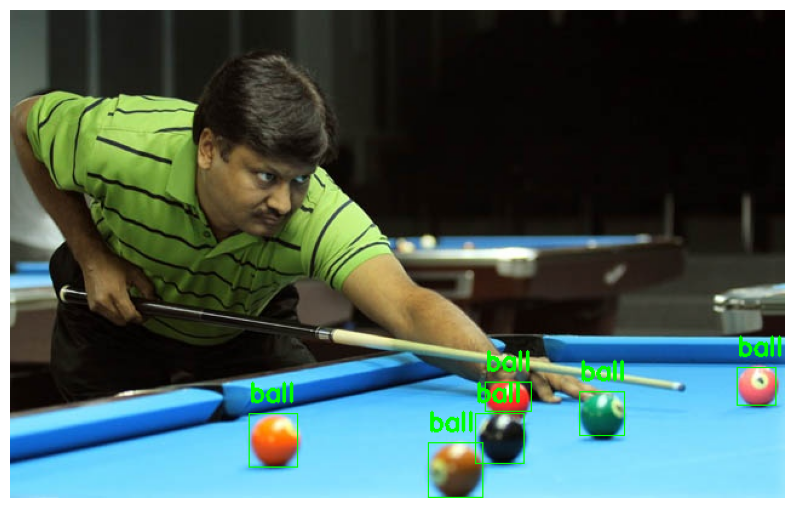

In [7]:
idx = 0

some_image = train_dataset[idx]['img']
some_bboxes = train_dataset[idx]['bboxes']

show_image_with_boxes(some_image, some_bboxes)

In [8]:
def make_targets(annotations, device):
    targets = []

    for annot in annotations:
        if len(annot) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32, device=device)
            labels = torch.zeros(0, dtype=torch.int64, device=device)
        else:
            boxes = annot[:, :4].to(device)
            labels = annot[:, 4].to(device).long()

        targets.append({
            'boxes': boxes,
            'labels': labels
        })

    return targets

In [15]:
def train(model, train_loader, val_loader, num_epochs=10, lr=1e-4, device='cpu'):
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        train_batches = 0

        train_pbar = tqdm(train_loader, desc=f"Train Epoch {epoch + 1}")

        for batch_idx, (images, annotations) in enumerate(train_pbar):
            images = images.to(device)

            targets = make_targets(annotations, device)

            optimizer.zero_grad()
            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())

            losses.backward()
            optimizer.step()

            epoch_train_loss += losses.item()
            train_batches += 1

            train_pbar.set_postfix({
                'Loss': f'{losses.item():.4f}',
                'Avg Loss': f'{epoch_train_loss/train_batches:.4f}'
            })

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        epoch_val_loss = 0.0
        val_batches = 0

        val_pbar = tqdm(val_loader, desc=f"Val Epoch {epoch+1}")

        with torch.no_grad():
            for images, annotations in val_pbar:
                images = images.to(device)
                targets = make_targets(annotations, device)

                detections = model(images)
                model.train()
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                model.eval()

                epoch_val_loss += losses.item()
                val_batches += 1

                val_pbar.set_postfix({
                    'Val Loss': f'{losses.item():.4f}'
                })

        avg_val_loss = epoch_val_loss / val_batches
        val_losses.append(avg_val_loss)

        scheduler.step()

        print(f"Epoch {epoch+1} Summary:")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss:   {avg_val_loss:.4f}")
        print(f"  Learning Rate: {scheduler.get_last_lr()[0]:.2e}")

        if (epoch + 1) % 2 == 0:
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'train_losses': train_losses,
                'val_losses': val_losses
            }
            torch.save(checkpoint, f'ssd_checkpoint_epoch_{epoch+1}.pth')
            print(f"Checkpoint saved: ssd_checkpoint_epoch_{epoch+1}.pth")
    return model, train_losses, val_losses

In [10]:
def filter_predictions(predictions, ball_class_id=37, confidence_threshold=0.5):
    filtered_predictions = []

    for pred in predictions:
        ball_mask = (pred['labels'] == ball_class_id) & (pred['scores'] > confidence_threshold)

        filtered_pred = {
            'boxes': pred['boxes'][ball_mask],
            'scores': pred['scores'][ball_mask],
            'labels': pred['labels'][ball_mask]
        }
        filtered_predictions.append(filtered_pred)

    return filtered_predictions

def predict_balls(model, images, device='cuda', confidence_threshold=0.5, ball_class_id=37):
    model.eval()
    with torch.no_grad():
        predictions = model(images.to(device))
        return filter_predictions(predictions, ball_class_id, confidence_threshold)

In [11]:
model = ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT)
model.eval()

train_loader = DetectionDataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DetectionDataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Обучаем модель:

In [33]:
trained_model, train_losses, val_losses = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,
    lr=1e-4,
    device=device
)

Val Epoch 1: 100%|██████████| 57/57 [00:12<00:00,  4.42it/s, Val Loss=4.8269]


Epoch 1 Summary:
  Train Loss: 1.8237
  Val Loss:   2.7516
  Learning Rate: 1.00e-04


Val Epoch 2: 100%|██████████| 57/57 [00:12<00:00,  4.41it/s, Val Loss=5.0341]


Epoch 2 Summary:
  Train Loss: 1.6065
  Val Loss:   2.6511
  Learning Rate: 1.00e-04
Checkpoint saved: ssd_checkpoint_epoch_2.pth


Val Epoch 3: 100%|██████████| 57/57 [00:13<00:00,  4.34it/s, Val Loss=5.7649]


Epoch 3 Summary:
  Train Loss: 1.3791
  Val Loss:   2.9514
  Learning Rate: 1.00e-05


Val Epoch 4: 100%|██████████| 57/57 [00:13<00:00,  4.35it/s, Val Loss=5.0759]


Epoch 4 Summary:
  Train Loss: 0.9885
  Val Loss:   2.6905
  Learning Rate: 1.00e-05
Checkpoint saved: ssd_checkpoint_epoch_4.pth


Val Epoch 5: 100%|██████████| 57/57 [00:13<00:00,  4.36it/s, Val Loss=5.2342]


Epoch 5 Summary:
  Train Loss: 0.8444
  Val Loss:   2.7689
  Learning Rate: 1.00e-05


Val Epoch 6: 100%|██████████| 57/57 [00:13<00:00,  4.38it/s, Val Loss=4.6923]


Epoch 6 Summary:
  Train Loss: 0.7691
  Val Loss:   2.7809
  Learning Rate: 1.00e-06
Checkpoint saved: ssd_checkpoint_epoch_6.pth


Val Epoch 7: 100%|██████████| 57/57 [00:12<00:00,  4.42it/s, Val Loss=4.9289]


Epoch 7 Summary:
  Train Loss: 0.7060
  Val Loss:   2.8294
  Learning Rate: 1.00e-06


Val Epoch 8: 100%|██████████| 57/57 [00:13<00:00,  4.18it/s, Val Loss=4.9989]


Epoch 8 Summary:
  Train Loss: 0.6904
  Val Loss:   2.8535
  Learning Rate: 1.00e-06
Checkpoint saved: ssd_checkpoint_epoch_8.pth


Val Epoch 9: 100%|██████████| 57/57 [00:13<00:00,  4.31it/s, Val Loss=5.0110]


Epoch 9 Summary:
  Train Loss: 0.6847
  Val Loss:   2.8611
  Learning Rate: 1.00e-07


Val Epoch 10: 100%|██████████| 57/57 [00:13<00:00,  4.21it/s, Val Loss=5.0187]


Epoch 10 Summary:
  Train Loss: 0.6768
  Val Loss:   2.8637
  Learning Rate: 1.00e-07
Checkpoint saved: ssd_checkpoint_epoch_10.pth


Рассчитаем метрику mAP@50:

In [35]:
def map_calculation(model, dataloader, device='cuda', num_batches=10):
    model.eval()

    metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=False, num_classes=2)

    with torch.no_grad():
        for batch_idx, (images, annotations) in enumerate(dataloader):
            if batch_idx >= num_batches:
                break

            images = images.to(device)
            predictions = model(images)

            for pred, gt_annot in zip(predictions, annotations):
                ball_mask = pred['labels'] == 37
                if ball_mask.sum() > 0:
                    pred_boxes = pred['boxes'][ball_mask].cpu().numpy()
                    pred_scores = pred['scores'][ball_mask].cpu().numpy()

                    detections = np.zeros((len(pred_boxes), 6))
                    detections[:, :4] = pred_boxes
                    detections[:, 4] = pred_scores
                    detections[:, 5] = 1
                else:
                    detections = np.zeros((0, 6))

                if len(gt_annot) > 0:
                    gt_boxes = gt_annot[:, :4].numpy()

                    ground_truths = np.zeros((len(gt_boxes), 7))
                    ground_truths[:, :4] = gt_boxes
                    ground_truths[:, 4] = 1
                    ground_truths[:, 5] = 0
                    ground_truths[:, 6] = 0
                else:
                    ground_truths = np.zeros((0, 7))

                metric_fn.add(detections, ground_truths)

    map_50 = metric_fn.value(iou_thresholds=0.5)['mAP']
    print(f"mAP@0.50 (first {num_batches} batches): {map_50:.4f}")

    return map_50

map50 = map_calculation(trained_model, val_loader, device=device, num_batches=50)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/mean_average_precision/mean_average_precision_2d.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.match_table[c] = pd.concat([self.match_table[c], match_table], axis=0, join='outer')


mAP@0.50 (first 50 batches): 0.0081


Посмотрим на какое-нибудь предсказание дообученной модели:

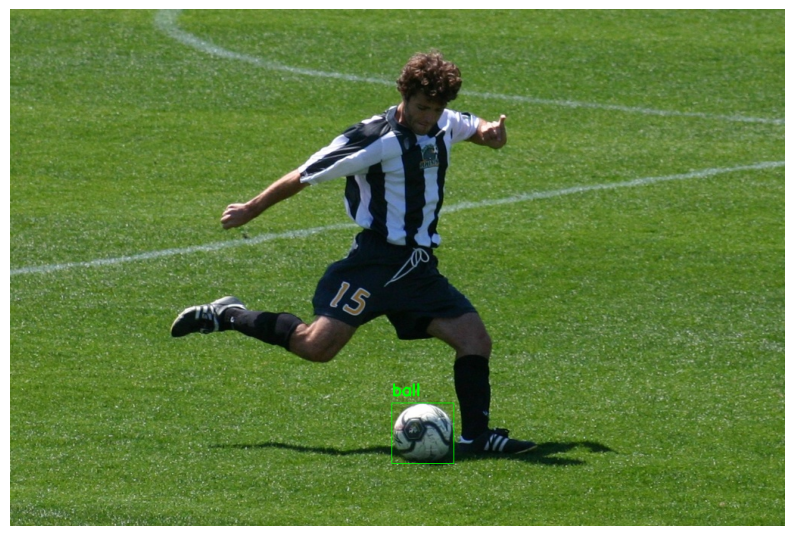

In [32]:
import random
sample_idx = random.randint(0, len(val_dataset) - 1)
sample = val_dataset[sample_idx]

trained_model.eval()
with torch.no_grad():
    image_tensor = sample['img'].unsqueeze(0).to(device)
    predictions = trained_model(image_tensor)
    pred = predictions[0]

ball_mask = pred['labels'] == 37
confidence_mask = pred['scores'] > 0.3
mask = ball_mask & confidence_mask

filtered_boxes = pred['boxes'][mask].cpu().numpy()
filtered_scores = pred['scores'][mask].cpu().numpy()

image_display = sample['img'].cpu().permute(1, 2, 0).numpy()
if image_display.max() <= 1.0:
    image_display = (image_display * 255).astype(np.uint8)

show_image_with_boxes(image_display, filtered_boxes)